In [8]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import SwinModel
from transformers.models.swin.modeling_swin import SwinLayer

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import torch
import torch.nn as nn
from transformers.models.swin.modeling_swin import SwinPatchEmbeddings, SwinPatchMerging, SwinLayer
from transformers import SwinConfig
from typing import Tuple, Optional
# --- Cài đặt tham số cố định ---
IMG_SIZE = 320 
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
SEED = 42
BATCH_SIZE = 2
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Đường dẫn dữ liệu (Thay đổi nếu cần) ---
train_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\image'
train_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\label'
val_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\image'
val_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\label'

# --- Thu thập đường dẫn tệp ảnh và mask ---
train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])


Using device: cuda


In [9]:
class CrackDetectionDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, transform=None):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_filenames[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_filenames[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask > 0, 255.0, 0.0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        mask = mask / 255.0
        mask = mask.unsqueeze(0)

        return img, mask

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [ ]:
class PatchExpanding(nn.Module):
    def __init__(self, input_resolution: Tuple[int, int], dim: int, return_vector: bool = True):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(dim // 2)
        self.return_vector = return_vector

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        H, W = self.input_resolution
        x = x.view(-1, H, W, self.dim)
        x = self.expand(x)
        B, H, W, C = x.shape
        x = x.view(B, H, W, 2, 2, C // 4)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H * 2, W * 2, C // 4)
        x = self.norm(x)
        if self.return_vector:
            x = x.view(B, -1, C // 4)
        return x


class FinalPatchExpanding(nn.Module):
    def __init__(self, dim: int, scale_factor: int = 4):
        super().__init__()
        self.scale_factor = scale_factor
        self.output_dim = dim // scale_factor

        expand_dim = self.output_dim * (scale_factor**2)
        self.expand = nn.Linear(dim, expand_dim, bias=False)

        self.norm = nn.LayerNorm(self.output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.shape
        H = W = int(np.sqrt(L))
        x_expanded = self.expand(x)

        x_reshaped = x_expanded.view(B, H, W, self.scale_factor, self.scale_factor, self.output_dim)

        x_permuted = x_reshaped.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H * self.scale_factor, W * self.scale_factor, self.output_dim)

        x_normed = self.norm(x_permuted)

        output = x_normed.view(B, -1, self.output_dim)
        
        return output


class SkipAttention(nn.Module):
    def __init__(self, query_dim: int, context_dim: Optional[int] = None, num_heads: int = 8, dim_head: int = 64):
        super().__init__()
        if context_dim is None:
            context_dim = query_dim
        
        self.attn = nn.MultiheadAttention(embed_dim=query_dim, num_heads=num_heads, 
                                          kdim=context_dim, vdim=context_dim, 
                                          batch_first=True)
        self.norm = nn.LayerNorm(query_dim)

    def forward(self, query: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        attn_output, _ = self.attn(query=query, key=context, value=context)
        return self.norm(query + attn_output)


class ResidualSwinBlock(nn.Module):
    def __init__(self, config: SwinConfig, dim: int, input_resolution: Tuple[int, int], num_layers: int, num_heads: int):
        super().__init__()
        self.layers = nn.ModuleList([
            SwinLayer(
                config=config, 
                dim=dim, 
                input_resolution=input_resolution, 
                num_heads=num_heads, 
                shift_size=0 if (i % 2 == 0) else config.window_size // 2
            ) for i in range(num_layers)
        ])
        
    def forward(self, x: torch.Tensor, input_resolution: Tuple[int, int]) -> torch.Tensor:
        residual = x
        for layer in self.layers:
            x = layer(x, input_resolution)[0]
        return x + residual


class iSwinUnet(nn.Module):
    def __init__(self, num_classes: int = 1, img_size: int = 320, pretrained: bool = True):
        super().__init__()
        self.num_classes = num_classes
        self.img_size = img_size
        
        # --- Config ---
        config = SwinConfig(image_size=img_size, patch_size=4, window_size=7)
        self.config = config
        self.encoder_channels = [config.embed_dim * (2**i) for i in range(len(config.depths))]

        # --- Encoder ---
        self.patch_embed = SwinPatchEmbeddings(config)
        self.pos_drop = nn.Dropout(p=config.hidden_dropout_prob)

        self.encoder_stage1 = ResidualSwinBlock(config, self.encoder_channels[0], (img_size//4, img_size//4), config.depths[0], config.num_heads[0])
        self.merge1 = SwinPatchMerging(input_resolution=(img_size//4, img_size//4), dim=self.encoder_channels[0])
        
        self.encoder_stage2 = ResidualSwinBlock(config, self.encoder_channels[1], (img_size//8, img_size//8), config.depths[1], config.num_heads[1])
        self.merge2 = SwinPatchMerging(input_resolution=(img_size//8, img_size//8), dim=self.encoder_channels[1])

        self.encoder_stage3 = ResidualSwinBlock(config, self.encoder_channels[2], (img_size//16, img_size//16), config.depths[2], config.num_heads[2])
        self.merge3 = SwinPatchMerging(input_resolution=(img_size//16, img_size//16), dim=self.encoder_channels[2])
        
        self.bottleneck = ResidualSwinBlock(config, self.encoder_channels[3], (img_size//32, img_size//32), config.depths[3], config.num_heads[3])

        self.decoder_expand3 = PatchExpanding(input_resolution=(img_size//32, img_size//32), dim=self.encoder_channels[3])
        self.skip_attn3 = SkipAttention(query_dim=self.encoder_channels[2], context_dim=self.encoder_channels[2], num_heads=config.num_heads[2])
        self.decoder_stage3 = ResidualSwinBlock(config, self.encoder_channels[2], (img_size//16, img_size//16), config.depths[2], config.num_heads[2])

        self.decoder_expand2 = PatchExpanding(input_resolution=(img_size//16, img_size//16), dim=self.encoder_channels[2])
        self.skip_attn2 = SkipAttention(query_dim=self.encoder_channels[1], context_dim=self.encoder_channels[1], num_heads=config.num_heads[1])
        self.decoder_stage2 = ResidualSwinBlock(config, self.encoder_channels[1], (img_size//8, img_size//8), config.depths[1], config.num_heads[1])

        self.decoder_expand1 = PatchExpanding(input_resolution=(img_size//8, img_size//8), dim=self.encoder_channels[1])
        self.skip_attn1 = SkipAttention(query_dim=self.encoder_channels[0], context_dim=self.encoder_channels[0], num_heads=config.num_heads[0])
        self.decoder_stage1 = ResidualSwinBlock(config, self.encoder_channels[0], (img_size//4, img_size//4), config.depths[0], config.num_heads[0])

        self.final_expand = FinalPatchExpanding(dim=self.encoder_channels[0], scale_factor=4)
        self.final_conv = nn.Conv2d(self.final_expand.output_dim, num_classes, kernel_size=1)

        if pretrained:
            self.load_pretrained_weights()

    def load_pretrained_weights(self):
            print("Loading pretrained weights for Swin-Tiny encoder...")
            try:
                swin_original = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
                original_state_dict = swin_original.state_dict()

                model_state_dict = self.state_dict()

                prefix_mapping = {
                    'embeddings.patch_embeddings': 'patch_embed',
                    'encoder.layers.0.downsample': 'merge1',
                    'encoder.layers.1.downsample': 'merge2',
                    'encoder.layers.2.downsample': 'merge3',
                }

                stage_mapping = {
                    'encoder.layers.0': 'encoder_stage1',
                    'encoder.layers.1': 'encoder_stage2',
                    'encoder.layers.2': 'encoder_stage3',
                    'encoder.layers.3': 'bottleneck',
                }

                loaded_count = 0
                
                orig_pos_embed_key = 'embeddings.absolute_position_embedding'
                if orig_pos_embed_key in original_state_dict:
                    orig_pos_embed = original_state_dict[orig_pos_embed_key]
                    target_pos_embed = model_state_dict[orig_pos_embed_key]
                    if orig_pos_embed.shape != target_pos_embed.shape:
                        print(f"Interpolating absolute position embedding due to size mismatch...")
                        orig_pos_embed_spatial = orig_pos_embed[0, 1:, :].permute(1, 0)

                        H_orig = W_orig = int((orig_pos_embed.shape[1] - 1) ** 0.5)
                        orig_pos_embed_spatial = orig_pos_embed_spatial.view(1, -1, H_orig, W_orig)
                        H_target = W_target = int((target_pos_embed.shape[1] - 1) ** 0.5)
                        interp_pos_embed = nn.functional.interpolate(
                            orig_pos_embed_spatial, size=(H_target, W_target), mode='bicubic', align_corners=False
                        )
                        interp_pos_embed = interp_pos_embed.view(1, -1, H_target * W_target).permute(0, 2, 1)
                        # Thêm lại token [CLS]
                        final_pos_embed = torch.cat((orig_pos_embed[0, 0:1, :], interp_pos_embed[0]), dim=0).unsqueeze(0)
                        model_state_dict[orig_pos_embed_key] = final_pos_embed
                        loaded_count += 1
                    del original_state_dict[orig_pos_embed_key]

                for key_orig, value in original_state_dict.items():
                    new_key = None

                    if 'pooler' in key_orig:
                        continue

                    for old_prefix, new_prefix in prefix_mapping.items():
                        if key_orig.startswith(old_prefix):
                            new_key = key_orig.replace(old_prefix, new_prefix)
                            break

                    if new_key is None:
                        for old_stage_prefix, new_stage_prefix in stage_mapping.items():
                            if key_orig.startswith(old_stage_prefix):
                                remainder = key_orig[len(old_stage_prefix):]
                                if remainder.startswith('.blocks'):
                                    remainder = remainder.replace('.blocks', '', 1)
                                    new_key = f"{new_stage_prefix}.layers{remainder}"
                                break

                    if new_key is None:
                        if key_orig.startswith('embeddings.norm'):
                            new_key = key_orig.replace('embeddings.norm', 'patch_embed.norm')
                        elif key_orig.startswith('encoder.norm'):
                            continue

                    if new_key and new_key in model_state_dict and model_state_dict[new_key].shape == value.shape:
                        model_state_dict[new_key] = value
                        loaded_count += 1
                    else:
                        pass

                self.load_state_dict(model_state_dict, strict=False)

                expected_keys = len([k for k in swin_original.state_dict().keys() if 'pooler' not in k and 'encoder.norm' not in k])
                print(f"✅ Successfully loaded {loaded_count}/{expected_keys} tensors from pretrained Swin-Tiny.")
                print("   (Any unloaded tensors are expected to be from the decoder and final layers).")

            except Exception as e:
                print(f"❌ ERROR: Could not load pretrained weights. Error: {e}. Training from scratch.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s1_skip = self.patch_embed(x)[0]
        s1_skip = self.pos_drop(s1_skip)
        
        s1_out = self.encoder_stage1(s1_skip, (self.img_size//4, self.img_size//4))
        s2_in = self.merge1(s1_out, (self.img_size//4, self.img_size//4))
        
        s2_out = self.encoder_stage2(s2_in, (self.img_size//8, self.img_size//8))
        s3_in = self.merge2(s2_out, (self.img_size//8, self.img_size//8))

        s3_out = self.encoder_stage3(s3_in, (self.img_size//16, self.img_size//16))
        b_in = self.merge3(s3_out, (self.img_size//16, self.img_size//16))
        
        b_out = self.bottleneck(b_in, (self.img_size//32, self.img_size//32))
 
        d3_in = self.decoder_expand3(b_out)
        d3_in = self.skip_attn3(query=d3_in, context=s3_out)
        d3_out = self.decoder_stage3(d3_in, (self.img_size//16, self.img_size//16))
 
        d2_in = self.decoder_expand2(d3_out)
        d2_in = self.skip_attn2(query=d2_in, context=s2_out)
        d2_out = self.decoder_stage2(d2_in, (self.img_size//8, self.img_size//8))

        d1_in = self.decoder_expand1(d2_out)
        d1_in = self.skip_attn1(query=d1_in, context=s1_out)
        d1_out = self.decoder_stage1(d1_in, (self.img_size//4, self.img_size//4))
        
        final_features = self.final_expand(d1_out)
        
        B, L, C = final_features.shape
        H = W = int(np.sqrt(L))
        final_features = final_features.permute(0, 2, 1).contiguous().view(B, C, H, W)
        
        output = self.final_conv(final_features)
        
        return output

In [11]:

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Mô hình trả về logits, cần đưa qua sigmoid để có xác suất trong khoảng (0, 1)
        inputs = torch.sigmoid(inputs)
        
        # Làm phẳng inputs và targets để tính toán dễ dàng
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Tính toán intersection (phần giao) và union (phần hợp)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        
        # Tính IoU, thêm smooth để tránh chia cho 0
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        # Loss là 1 - IoU, vì mục tiêu của chúng ta là tối đa hóa IoU
        return 1 - iou


def calculate_metrics(predicted_masks, true_masks, smooth=1e-6):
    predicted_masks = predicted_masks.view(-1)
    true_masks = true_masks.view(-1)
    
    intersection = (predicted_masks * true_masks).sum()
    union = (predicted_masks + true_masks).sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    dice = (2. * intersection + smooth) / (predicted_masks.sum() + true_masks.sum() + smooth)
    
    return iou.item(), dice.item()

In [12]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, callbacks_config, start_epoch=0, best_val_iou=0.0, history=None):
    best_iou = best_val_iou
    patience_counter = 0
    checkpoint_path = callbacks_config.get('checkpoint_path', 'model_best.pth')
    
    if history is None:
        history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': [], 'lr': []}

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss, train_iou = 0.0, 0.0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, masks in loop:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
            
            batch_iou, _ = calculate_metrics(predicted_masks, masks)
            train_iou += batch_iou
            
            loop.set_postfix(loss=loss.item(), iou=batch_iou)

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_iou'].append(train_iou / len(train_loader))
        
        model.eval()
        val_loss, val_iou = 0.0, 0.0
        
        loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for images, masks in loop:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
                
                batch_iou, _ = calculate_metrics(predicted_masks, masks)
                val_iou += batch_iou

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        
        history['val_loss'].append(avg_val_loss)
        history['val_iou'].append(avg_val_iou)
        
        scheduler.step(avg_val_loss) # Sử dụng validation loss cho scheduler
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train -> Loss: {history['train_loss'][-1]:.4f}, IoU: {history['train_iou'][-1]:.4f}")
        print(f"  Val   -> Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}")
        print(f"  LR: {current_lr:.8f}")

        if avg_val_iou > best_iou:
            best_iou = avg_val_iou
            patience_counter = 0
            print(f"🚀 New best validation IoU: {best_iou:.4f}. Saving model...")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_iou': best_iou,
                'scheduler_state_dict': scheduler.state_dict(),
                'history': history
            }, checkpoint_path)
        else:
            patience_counter += 1
            print(f"Validation IoU did not improve. Patience: {patience_counter}/{callbacks_config['patience']}")
            if patience_counter >= callbacks_config['patience']:
                print("Early stopping!")
                break
    return history

# --- Hàm vẽ biểu đồ (Đã chỉnh sửa chỉ dùng IoU) ---
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Sửa đổi: Tạo một hàng 3 cột cho 3 biểu đồ
    fig, axs = plt.subplots(1, 3, figsize=(22, 6))

    # Biểu đồ 1: Loss
    axs[0].plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    axs[0].plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set(xlabel='Epoch', ylabel='Loss')
    axs[0].legend()

    # Biểu đồ 2: IoU
    axs[1].plot(epochs, history['train_iou'], 'o-', label='Train IoU')
    axs[1].plot(epochs, history['val_iou'], 'o-', label='Validation IoU')
    axs[1].set_title('Training and Validation IoU')
    axs[1].set(xlabel='Epoch', ylabel='IoU')
    axs[1].legend()

    axs[2].plot(epochs, history['lr'], 'o-', label='Learning Rate', color='purple')
    axs[2].set_title('Learning Rate per Epoch')
    axs[2].set(xlabel='Epoch', ylabel='Learning Rate')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)
            preds = torch.sigmoid(outputs)

            preds = (preds > threshold).float()

            all_preds.append(preds.view(-1).cpu().numpy())
            all_targets.append(masks.view(-1).cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)

    print(f"\n--- Evaluation Metrics ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"IoU:       {iou:.4f}")


Initializing iSwinUnet model (paper version)...
Loading pretrained weights for Swin-Tiny encoder...
✅ Successfully loaded 227/231 tensors from pretrained Swin-Tiny.
   (Any unloaded tensors are expected to be from the decoder and final layers).
!!! USING BCEWithLogitsLoss with pos_weight=30 !!!
Model has 41,657,773 trainable parameters.
Checkpoint found. Loading...


C:\Users\Admin\AppData\Local\Temp\ipykernel_29240\1052588386.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu'

Resuming from Epoch 0. Best Val IoU so far: 0.4962

--- Starting Training ---


Epoch 1/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.28it/s]


Epoch 1 Summary:
  Train -> Loss: 0.4149, IoU: 0.5888
  Val   -> Loss: 0.5384, IoU: 0.4638
  LR: 0.00010000
Validation IoU did not improve. Patience: 1/30


Epoch 2/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.16it/s]


Epoch 2 Summary:
  Train -> Loss: 0.4154, IoU: 0.5860
  Val   -> Loss: 0.5276, IoU: 0.4736
  LR: 0.00010000
Validation IoU did not improve. Patience: 2/30


Epoch 3/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.42it/s]


Epoch 3 Summary:
  Train -> Loss: 0.4106, IoU: 0.5902
  Val   -> Loss: 0.5234, IoU: 0.4774
  LR: 0.00010000
Validation IoU did not improve. Patience: 3/30


Epoch 4/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.67it/s]


Epoch 4 Summary:
  Train -> Loss: 0.4161, IoU: 0.5846
  Val   -> Loss: 0.5212, IoU: 0.4793
  LR: 0.00010000
Validation IoU did not improve. Patience: 4/30


Epoch 5/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.88it/s]


Epoch 5 Summary:
  Train -> Loss: 0.4023, IoU: 0.5982
  Val   -> Loss: 0.5192, IoU: 0.4813
  LR: 0.00010000
Validation IoU did not improve. Patience: 5/30


Epoch 6/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.30it/s]


Epoch 6 Summary:
  Train -> Loss: 0.4074, IoU: 0.5930
  Val   -> Loss: 0.5241, IoU: 0.4764
  LR: 0.00010000
Validation IoU did not improve. Patience: 6/30


Epoch 7/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.65it/s]


Epoch 7 Summary:
  Train -> Loss: 0.4074, IoU: 0.5930
  Val   -> Loss: 0.5182, IoU: 0.4822
  LR: 0.00010000
Validation IoU did not improve. Patience: 7/30


Epoch 8/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.88it/s]


Epoch 8 Summary:
  Train -> Loss: 0.4022, IoU: 0.5981
  Val   -> Loss: 0.5114, IoU: 0.4889
  LR: 0.00010000
Validation IoU did not improve. Patience: 8/30


Epoch 9/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.34it/s]


Epoch 9 Summary:
  Train -> Loss: 0.4116, IoU: 0.5886
  Val   -> Loss: 0.5355, IoU: 0.4647
  LR: 0.00010000
Validation IoU did not improve. Patience: 9/30


Epoch 10/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


Epoch 10 Summary:
  Train -> Loss: 0.4130, IoU: 0.5872
  Val   -> Loss: 0.5179, IoU: 0.4825
  LR: 0.00010000
Validation IoU did not improve. Patience: 10/30


Epoch 11/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.98it/s]


Epoch 11 Summary:
  Train -> Loss: 0.4068, IoU: 0.5934
  Val   -> Loss: 0.5221, IoU: 0.4781
  LR: 0.00010000
Validation IoU did not improve. Patience: 11/30


Epoch 12/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.49it/s]


Epoch 12 Summary:
  Train -> Loss: 0.4025, IoU: 0.5977
  Val   -> Loss: 0.5125, IoU: 0.4877
  LR: 0.00010000
Validation IoU did not improve. Patience: 12/30


Epoch 13/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.67it/s]


Epoch 13 Summary:
  Train -> Loss: 0.4012, IoU: 0.5990
  Val   -> Loss: 0.5097, IoU: 0.4905
  LR: 0.00010000
Validation IoU did not improve. Patience: 13/30


Epoch 14/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.99it/s]


Epoch 14 Summary:
  Train -> Loss: 0.3960, IoU: 0.6041
  Val   -> Loss: 0.5151, IoU: 0.4851
  LR: 0.00010000
Validation IoU did not improve. Patience: 14/30


Epoch 15/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.60it/s]


Epoch 15 Summary:
  Train -> Loss: 0.3931, IoU: 0.6070
  Val   -> Loss: 0.5084, IoU: 0.4917
  LR: 0.00010000
Validation IoU did not improve. Patience: 15/30


Epoch 16/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.56it/s]


Epoch 16 Summary:
  Train -> Loss: 0.3943, IoU: 0.6058
  Val   -> Loss: 0.5027, IoU: 0.4975
  LR: 0.00010000
🚀 New best validation IoU: 0.4975. Saving model...


Epoch 17/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.95it/s]


Epoch 17 Summary:
  Train -> Loss: 0.3923, IoU: 0.6079
  Val   -> Loss: 0.5083, IoU: 0.4918
  LR: 0.00010000
Validation IoU did not improve. Patience: 1/30


Epoch 18/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.63it/s]


Epoch 18 Summary:
  Train -> Loss: 0.3890, IoU: 0.6112
  Val   -> Loss: 0.5081, IoU: 0.4920
  LR: 0.00010000
Validation IoU did not improve. Patience: 2/30


Epoch 19/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.47it/s]


Epoch 19 Summary:
  Train -> Loss: 0.3976, IoU: 0.6025
  Val   -> Loss: 0.5120, IoU: 0.4882
  LR: 0.00010000
Validation IoU did not improve. Patience: 3/30


Epoch 20/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.37it/s]


Epoch 20 Summary:
  Train -> Loss: 0.4039, IoU: 0.5962
  Val   -> Loss: 0.5128, IoU: 0.4874
  LR: 0.00010000
Validation IoU did not improve. Patience: 4/30


Epoch 21/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.29it/s]


Epoch 21 Summary:
  Train -> Loss: 0.3955, IoU: 0.6046
  Val   -> Loss: 0.5084, IoU: 0.4917
  LR: 0.00010000
Validation IoU did not improve. Patience: 5/30


Epoch 22/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.53it/s]


Epoch 22 Summary:
  Train -> Loss: 0.3895, IoU: 0.6107
  Val   -> Loss: 0.5072, IoU: 0.4930
  LR: 0.00005000
Validation IoU did not improve. Patience: 6/30


Epoch 23/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.15it/s]


Epoch 23 Summary:
  Train -> Loss: 0.3794, IoU: 0.6207
  Val   -> Loss: 0.4944, IoU: 0.5057
  LR: 0.00005000
🚀 New best validation IoU: 0.5057. Saving model...


Epoch 24/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.76it/s]


Epoch 24 Summary:
  Train -> Loss: 0.3664, IoU: 0.6337
  Val   -> Loss: 0.4906, IoU: 0.5096
  LR: 0.00005000
🚀 New best validation IoU: 0.5096. Saving model...


Epoch 25/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.42it/s]


Epoch 25 Summary:
  Train -> Loss: 0.3635, IoU: 0.6366
  Val   -> Loss: 0.4916, IoU: 0.5086
  LR: 0.00005000
Validation IoU did not improve. Patience: 1/30


Epoch 26/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.47it/s]


Epoch 26 Summary:
  Train -> Loss: 0.3578, IoU: 0.6423
  Val   -> Loss: 0.4903, IoU: 0.5099
  LR: 0.00005000
🚀 New best validation IoU: 0.5099. Saving model...


Epoch 27/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.39it/s]


Epoch 27 Summary:
  Train -> Loss: 0.3660, IoU: 0.6340
  Val   -> Loss: 0.4966, IoU: 0.5036
  LR: 0.00005000
Validation IoU did not improve. Patience: 1/30


Epoch 28/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.17it/s]


Epoch 28 Summary:
  Train -> Loss: 0.3569, IoU: 0.6433
  Val   -> Loss: 0.4896, IoU: 0.5107
  LR: 0.00005000
🚀 New best validation IoU: 0.5107. Saving model...


Epoch 29/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.94it/s]


Epoch 29 Summary:
  Train -> Loss: 0.3571, IoU: 0.6431
  Val   -> Loss: 0.4901, IoU: 0.5101
  LR: 0.00005000
Validation IoU did not improve. Patience: 1/30


Epoch 30/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.14it/s]


Epoch 30 Summary:
  Train -> Loss: 0.3587, IoU: 0.6414
  Val   -> Loss: 0.4869, IoU: 0.5133
  LR: 0.00005000
🚀 New best validation IoU: 0.5133. Saving model...


Epoch 31/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Epoch 31 Summary:
  Train -> Loss: 0.3523, IoU: 0.6478
  Val   -> Loss: 0.4954, IoU: 0.5048
  LR: 0.00005000
Validation IoU did not improve. Patience: 1/30


Epoch 32/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.37it/s]


Epoch 32 Summary:
  Train -> Loss: 0.3515, IoU: 0.6487
  Val   -> Loss: 0.4899, IoU: 0.5102
  LR: 0.00005000
Validation IoU did not improve. Patience: 2/30


Epoch 33/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.39it/s]


Epoch 33 Summary:
  Train -> Loss: 0.3514, IoU: 0.6487
  Val   -> Loss: 0.4876, IoU: 0.5125
  LR: 0.00005000
Validation IoU did not improve. Patience: 3/30


Epoch 34/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.19it/s]


Epoch 34 Summary:
  Train -> Loss: 0.3475, IoU: 0.6526
  Val   -> Loss: 0.4941, IoU: 0.5062
  LR: 0.00005000
Validation IoU did not improve. Patience: 4/30


Epoch 35/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.28it/s]


Epoch 35 Summary:
  Train -> Loss: 0.3532, IoU: 0.6469
  Val   -> Loss: 0.4929, IoU: 0.5073
  LR: 0.00005000
Validation IoU did not improve. Patience: 5/30


Epoch 36/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.08it/s]


Epoch 36 Summary:
  Train -> Loss: 0.3524, IoU: 0.6477
  Val   -> Loss: 0.4914, IoU: 0.5087
  LR: 0.00002500
Validation IoU did not improve. Patience: 6/30


Epoch 37/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.09it/s]


Epoch 37 Summary:
  Train -> Loss: 0.3430, IoU: 0.6571
  Val   -> Loss: 0.4853, IoU: 0.5149
  LR: 0.00002500
🚀 New best validation IoU: 0.5149. Saving model...


Epoch 38/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.11it/s]


Epoch 38 Summary:
  Train -> Loss: 0.3301, IoU: 0.6701
  Val   -> Loss: 0.4858, IoU: 0.5143
  LR: 0.00002500
Validation IoU did not improve. Patience: 1/30


Epoch 39/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.40it/s]


Epoch 39 Summary:
  Train -> Loss: 0.3391, IoU: 0.6610
  Val   -> Loss: 0.4899, IoU: 0.5103
  LR: 0.00002500
Validation IoU did not improve. Patience: 2/30


Epoch 40/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.14it/s]


Epoch 40 Summary:
  Train -> Loss: 0.3359, IoU: 0.6642
  Val   -> Loss: 0.4847, IoU: 0.5154
  LR: 0.00002500
🚀 New best validation IoU: 0.5154. Saving model...


Epoch 41/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.16it/s]


Epoch 41 Summary:
  Train -> Loss: 0.3285, IoU: 0.6716
  Val   -> Loss: 0.4847, IoU: 0.5154
  LR: 0.00002500
🚀 New best validation IoU: 0.5154. Saving model...


Epoch 42/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.42it/s]


Epoch 42 Summary:
  Train -> Loss: 0.3276, IoU: 0.6725
  Val   -> Loss: 0.4833, IoU: 0.5168
  LR: 0.00002500
🚀 New best validation IoU: 0.5168. Saving model...


Epoch 43/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.32it/s]


Epoch 43 Summary:
  Train -> Loss: 0.3253, IoU: 0.6749
  Val   -> Loss: 0.4851, IoU: 0.5150
  LR: 0.00002500
Validation IoU did not improve. Patience: 1/30


Epoch 44/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.18it/s]


Epoch 44 Summary:
  Train -> Loss: 0.3300, IoU: 0.6701
  Val   -> Loss: 0.4839, IoU: 0.5162
  LR: 0.00002500
Validation IoU did not improve. Patience: 2/30


Epoch 45/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.27it/s]


Epoch 45 Summary:
  Train -> Loss: 0.3256, IoU: 0.6745
  Val   -> Loss: 0.4855, IoU: 0.5147
  LR: 0.00002500
Validation IoU did not improve. Patience: 3/30


Epoch 46/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.08it/s]


Epoch 46 Summary:
  Train -> Loss: 0.3294, IoU: 0.6707
  Val   -> Loss: 0.4827, IoU: 0.5175
  LR: 0.00002500
🚀 New best validation IoU: 0.5175. Saving model...


Epoch 47/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Epoch 47 Summary:
  Train -> Loss: 0.3272, IoU: 0.6730
  Val   -> Loss: 0.4858, IoU: 0.5142
  LR: 0.00002500
Validation IoU did not improve. Patience: 1/30


Epoch 48/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.16it/s]


Epoch 48 Summary:
  Train -> Loss: 0.3200, IoU: 0.6802
  Val   -> Loss: 0.4869, IoU: 0.5133
  LR: 0.00002500
Validation IoU did not improve. Patience: 2/30


Epoch 49/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.51it/s]


Epoch 49 Summary:
  Train -> Loss: 0.3301, IoU: 0.6701
  Val   -> Loss: 0.4882, IoU: 0.5120
  LR: 0.00002500
Validation IoU did not improve. Patience: 3/30


Epoch 50/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.49it/s]


Epoch 50 Summary:
  Train -> Loss: 0.3246, IoU: 0.6756
  Val   -> Loss: 0.4825, IoU: 0.5177
  LR: 0.00002500
🚀 New best validation IoU: 0.5177. Saving model...


Epoch 51/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.25it/s]


Epoch 51 Summary:
  Train -> Loss: 0.3190, IoU: 0.6811
  Val   -> Loss: 0.4842, IoU: 0.5159
  LR: 0.00002500
Validation IoU did not improve. Patience: 1/30


Epoch 52/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.85it/s]


Epoch 52 Summary:
  Train -> Loss: 0.3195, IoU: 0.6807
  Val   -> Loss: 0.4835, IoU: 0.5166
  LR: 0.00002500
Validation IoU did not improve. Patience: 2/30


Epoch 53/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Epoch 53 Summary:
  Train -> Loss: 0.3172, IoU: 0.6830
  Val   -> Loss: 0.4841, IoU: 0.5161
  LR: 0.00002500
Validation IoU did not improve. Patience: 3/30


Epoch 54/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.07it/s]


Epoch 54 Summary:
  Train -> Loss: 0.3168, IoU: 0.6833
  Val   -> Loss: 0.4826, IoU: 0.5175
  LR: 0.00002500
Validation IoU did not improve. Patience: 4/30


Epoch 55/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.09it/s]


Epoch 55 Summary:
  Train -> Loss: 0.3154, IoU: 0.6847
  Val   -> Loss: 0.4861, IoU: 0.5140
  LR: 0.00002500
Validation IoU did not improve. Patience: 5/30


Epoch 56/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.20it/s]


Epoch 56 Summary:
  Train -> Loss: 0.3203, IoU: 0.6799
  Val   -> Loss: 0.4818, IoU: 0.5182
  LR: 0.00002500
🚀 New best validation IoU: 0.5182. Saving model...


Epoch 57/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.34it/s]


Epoch 57 Summary:
  Train -> Loss: 0.3178, IoU: 0.6823
  Val   -> Loss: 0.4844, IoU: 0.5157
  LR: 0.00002500
Validation IoU did not improve. Patience: 1/30


Epoch 58/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.25it/s]


Epoch 58 Summary:
  Train -> Loss: 0.3179, IoU: 0.6822
  Val   -> Loss: 0.4855, IoU: 0.5145
  LR: 0.00002500
Validation IoU did not improve. Patience: 2/30


Epoch 59/200 [Val]: 100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Epoch 59 Summary:
  Train -> Loss: 0.3144, IoU: 0.6857
  Val   -> Loss: 0.4828, IoU: 0.5173
  LR: 0.00002500
Validation IoU did not improve. Patience: 3/30


Epoch 60/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.84it/s]


Epoch 60 Summary:
  Train -> Loss: 0.3168, IoU: 0.6833
  Val   -> Loss: 0.4847, IoU: 0.5154
  LR: 0.00002500
Validation IoU did not improve. Patience: 4/30


Epoch 61/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.03it/s]


Epoch 61 Summary:
  Train -> Loss: 0.3144, IoU: 0.6857
  Val   -> Loss: 0.4838, IoU: 0.5164
  LR: 0.00002500
Validation IoU did not improve. Patience: 5/30


Epoch 62/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.57it/s]


Epoch 62 Summary:
  Train -> Loss: 0.3137, IoU: 0.6864
  Val   -> Loss: 0.4839, IoU: 0.5164
  LR: 0.00001250
Validation IoU did not improve. Patience: 6/30


Epoch 63/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 11.99it/s]


Epoch 63 Summary:
  Train -> Loss: 0.3092, IoU: 0.6909
  Val   -> Loss: 0.4839, IoU: 0.5162
  LR: 0.00001250
Validation IoU did not improve. Patience: 7/30


Epoch 64/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.24it/s]


Epoch 64 Summary:
  Train -> Loss: 0.3053, IoU: 0.6949
  Val   -> Loss: 0.4815, IoU: 0.5187
  LR: 0.00001250
🚀 New best validation IoU: 0.5187. Saving model...


Epoch 65/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.53it/s]


Epoch 65 Summary:
  Train -> Loss: 0.3059, IoU: 0.6942
  Val   -> Loss: 0.4832, IoU: 0.5170
  LR: 0.00001250
Validation IoU did not improve. Patience: 1/30


Epoch 66/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.49it/s]


Epoch 66 Summary:
  Train -> Loss: 0.3008, IoU: 0.6993
  Val   -> Loss: 0.4840, IoU: 0.5161
  LR: 0.00001250
Validation IoU did not improve. Patience: 2/30


Epoch 67/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


Epoch 67 Summary:
  Train -> Loss: 0.3024, IoU: 0.6977
  Val   -> Loss: 0.4832, IoU: 0.5169
  LR: 0.00001250
Validation IoU did not improve. Patience: 3/30


Epoch 68/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.65it/s]


Epoch 68 Summary:
  Train -> Loss: 0.3049, IoU: 0.6953
  Val   -> Loss: 0.4812, IoU: 0.5190
  LR: 0.00001250
🚀 New best validation IoU: 0.5190. Saving model...


Epoch 69/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.81it/s]


Epoch 69 Summary:
  Train -> Loss: 0.3014, IoU: 0.6988
  Val   -> Loss: 0.4824, IoU: 0.5178
  LR: 0.00001250
Validation IoU did not improve. Patience: 1/30


Epoch 70/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.61it/s]


Epoch 70 Summary:
  Train -> Loss: 0.3003, IoU: 0.6999
  Val   -> Loss: 0.4824, IoU: 0.5177
  LR: 0.00001250
Validation IoU did not improve. Patience: 2/30


Epoch 71/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.76it/s]


Epoch 71 Summary:
  Train -> Loss: 0.3044, IoU: 0.6957
  Val   -> Loss: 0.4813, IoU: 0.5189
  LR: 0.00001250
Validation IoU did not improve. Patience: 3/30


Epoch 72/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.75it/s]


Epoch 72 Summary:
  Train -> Loss: 0.2998, IoU: 0.7003
  Val   -> Loss: 0.4842, IoU: 0.5160
  LR: 0.00001250
Validation IoU did not improve. Patience: 4/30


Epoch 73/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.72it/s]


Epoch 73 Summary:
  Train -> Loss: 0.3020, IoU: 0.6981
  Val   -> Loss: 0.4832, IoU: 0.5169
  LR: 0.00001250
Validation IoU did not improve. Patience: 5/30


Epoch 74/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.80it/s]


Epoch 74 Summary:
  Train -> Loss: 0.2981, IoU: 0.7020
  Val   -> Loss: 0.4816, IoU: 0.5185
  LR: 0.00000625
Validation IoU did not improve. Patience: 6/30


Epoch 75/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.69it/s]


Epoch 75 Summary:
  Train -> Loss: 0.2953, IoU: 0.7049
  Val   -> Loss: 0.4812, IoU: 0.5190
  LR: 0.00000625
Validation IoU did not improve. Patience: 7/30


Epoch 76/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.77it/s]


Epoch 76 Summary:
  Train -> Loss: 0.2912, IoU: 0.7090
  Val   -> Loss: 0.4831, IoU: 0.5171
  LR: 0.00000625
Validation IoU did not improve. Patience: 8/30


Epoch 77/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.59it/s]


Epoch 77 Summary:
  Train -> Loss: 0.2961, IoU: 0.7040
  Val   -> Loss: 0.4827, IoU: 0.5174
  LR: 0.00000625
Validation IoU did not improve. Patience: 9/30


Epoch 78/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.56it/s]


Epoch 78 Summary:
  Train -> Loss: 0.2945, IoU: 0.7056
  Val   -> Loss: 0.4825, IoU: 0.5177
  LR: 0.00000625
Validation IoU did not improve. Patience: 10/30


Epoch 79/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.75it/s]


Epoch 79 Summary:
  Train -> Loss: 0.2934, IoU: 0.7068
  Val   -> Loss: 0.4819, IoU: 0.5183
  LR: 0.00000625
Validation IoU did not improve. Patience: 11/30


Epoch 80/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.68it/s]


Epoch 80 Summary:
  Train -> Loss: 0.2943, IoU: 0.7059
  Val   -> Loss: 0.4828, IoU: 0.5175
  LR: 0.00000313
Validation IoU did not improve. Patience: 12/30


Epoch 81/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


Epoch 81 Summary:
  Train -> Loss: 0.2919, IoU: 0.7083
  Val   -> Loss: 0.4830, IoU: 0.5172
  LR: 0.00000313
Validation IoU did not improve. Patience: 13/30


Epoch 82/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


Epoch 82 Summary:
  Train -> Loss: 0.2901, IoU: 0.7101
  Val   -> Loss: 0.4819, IoU: 0.5182
  LR: 0.00000313
Validation IoU did not improve. Patience: 14/30


Epoch 83/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.49it/s]


Epoch 83 Summary:
  Train -> Loss: 0.2896, IoU: 0.7106
  Val   -> Loss: 0.4823, IoU: 0.5179
  LR: 0.00000313
Validation IoU did not improve. Patience: 15/30


Epoch 84/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.43it/s]


Epoch 84 Summary:
  Train -> Loss: 0.2891, IoU: 0.7111
  Val   -> Loss: 0.4825, IoU: 0.5176
  LR: 0.00000313
Validation IoU did not improve. Patience: 16/30


Epoch 85/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.50it/s]


Epoch 85 Summary:
  Train -> Loss: 0.2894, IoU: 0.7108
  Val   -> Loss: 0.4826, IoU: 0.5176
  LR: 0.00000313
Validation IoU did not improve. Patience: 17/30


Epoch 86/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.49it/s]


Epoch 86 Summary:
  Train -> Loss: 0.2858, IoU: 0.7145
  Val   -> Loss: 0.4820, IoU: 0.5181
  LR: 0.00000156
Validation IoU did not improve. Patience: 18/30


Epoch 87/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.46it/s]


Epoch 87 Summary:
  Train -> Loss: 0.2919, IoU: 0.7083
  Val   -> Loss: 0.4821, IoU: 0.5181
  LR: 0.00000156
Validation IoU did not improve. Patience: 19/30


Epoch 88/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


Epoch 88 Summary:
  Train -> Loss: 0.2888, IoU: 0.7114
  Val   -> Loss: 0.4824, IoU: 0.5176
  LR: 0.00000156
Validation IoU did not improve. Patience: 20/30


Epoch 89/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


Epoch 89 Summary:
  Train -> Loss: 0.2907, IoU: 0.7095
  Val   -> Loss: 0.4820, IoU: 0.5182
  LR: 0.00000156
Validation IoU did not improve. Patience: 21/30


Epoch 90/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.53it/s]


Epoch 90 Summary:
  Train -> Loss: 0.2831, IoU: 0.7172
  Val   -> Loss: 0.4822, IoU: 0.5179
  LR: 0.00000156
Validation IoU did not improve. Patience: 22/30


Epoch 91/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.42it/s]


Epoch 91 Summary:
  Train -> Loss: 0.2924, IoU: 0.7079
  Val   -> Loss: 0.4821, IoU: 0.5180
  LR: 0.00000156
Validation IoU did not improve. Patience: 23/30


Epoch 92/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.48it/s]


Epoch 92 Summary:
  Train -> Loss: 0.2882, IoU: 0.7121
  Val   -> Loss: 0.4822, IoU: 0.5179
  LR: 0.00000078
Validation IoU did not improve. Patience: 24/30


Epoch 93/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.54it/s]


Epoch 93 Summary:
  Train -> Loss: 0.2891, IoU: 0.7111
  Val   -> Loss: 0.4823, IoU: 0.5178
  LR: 0.00000078
Validation IoU did not improve. Patience: 25/30


Epoch 94/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.41it/s]


Epoch 94 Summary:
  Train -> Loss: 0.2894, IoU: 0.7110
  Val   -> Loss: 0.4824, IoU: 0.5178
  LR: 0.00000078
Validation IoU did not improve. Patience: 26/30


Epoch 95/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.60it/s]


Epoch 95 Summary:
  Train -> Loss: 0.2831, IoU: 0.7172
  Val   -> Loss: 0.4822, IoU: 0.5179
  LR: 0.00000078
Validation IoU did not improve. Patience: 27/30


Epoch 96/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


Epoch 96 Summary:
  Train -> Loss: 0.2888, IoU: 0.7115
  Val   -> Loss: 0.4821, IoU: 0.5180
  LR: 0.00000078
Validation IoU did not improve. Patience: 28/30


Epoch 97/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.51it/s]


Epoch 97 Summary:
  Train -> Loss: 0.2849, IoU: 0.7154
  Val   -> Loss: 0.4822, IoU: 0.5180
  LR: 0.00000078
Validation IoU did not improve. Patience: 29/30


Epoch 98/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.75it/s]


Epoch 98 Summary:
  Train -> Loss: 0.2862, IoU: 0.7142
  Val   -> Loss: 0.4823, IoU: 0.5178
  LR: 0.00000039
Validation IoU did not improve. Patience: 30/30
Early stopping!

--- Training complete. ---
Plotting training history...


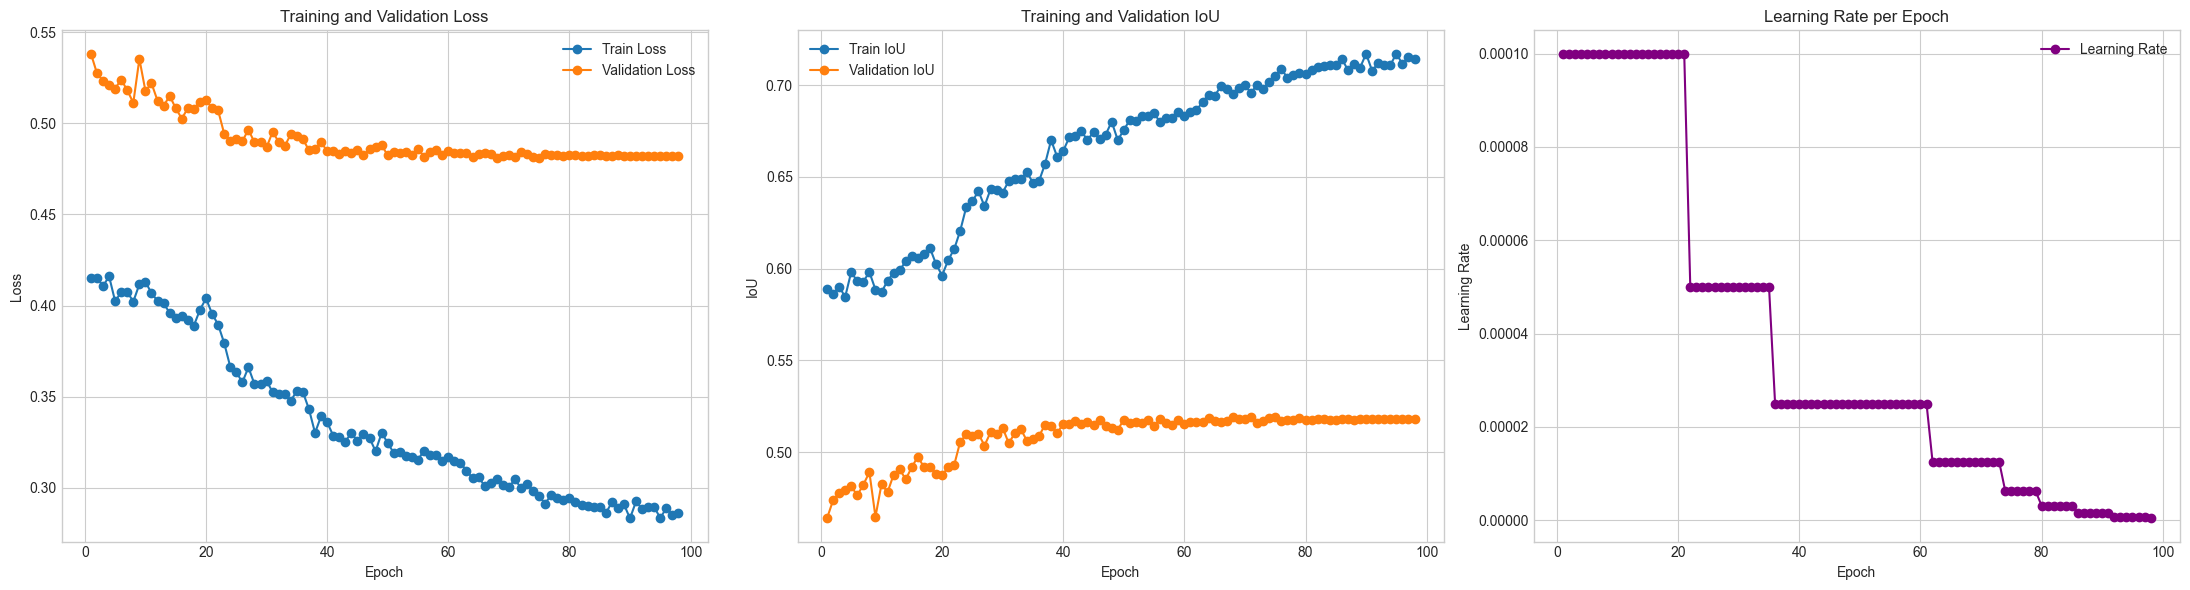


--- Evaluating the best model on the validation set ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_29240\1052588386.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_PATH)['model_st


--- Evaluation Metrics ---
Precision: 0.7188
Recall:    0.7486
F1-score:  0.7334
IoU:       0.5790


In [14]:
if __name__ == '__main__':
    # --- Chuẩn bị dữ liệu ---
    train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
    train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
    val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
    val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])

    train_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    train_dataset = CrackDetectionDataset(train_img_paths, train_mask_paths, transform=train_transform)
    val_dataset = CrackDetectionDataset(val_img_paths, val_mask_paths, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    # --- Khởi tạo Model, Optimizer, Loss ---
    print("Initializing iSwinUnet model (paper version)...")
    model = iSwinUnet(num_classes=1, img_size=IMG_SIZE, pretrained=True).to(DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)
    
    pos_weight_value = 30
    criterion = criterion = IoULoss()
    
    print("="*50)
    print(f"!!! USING BCEWithLogitsLoss with pos_weight={pos_weight_value} !!!")
    print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")
    print("="*50)

    CHECKPOINT_PATH = 'iswin_unet_paper_IOU.pth'
    callbacks_config = {'patience': 30, 'checkpoint_path': CHECKPOINT_PATH}

    start_epoch, best_val_iou, history = 0, 0.0, None
    if os.path.exists(CHECKPOINT_PATH):
        print(f"Checkpoint found. Loading...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(DEVICE)
        best_val_iou = checkpoint.get('best_val_iou', 0.0)
        print(f"Resuming from Epoch {start_epoch}. Best Val IoU so far: {best_val_iou:.4f}")
    else:
        print("No checkpoint found. Starting from scratch.")

    # --- Bắt đầu Huấn luyện ---
    print(f"\n--- Starting Training ---")
    training_history = train_model(
        model, train_loader, val_loader, optimizer, criterion, scheduler,
        num_epochs=NUM_EPOCHS, callbacks_config=callbacks_config,
        start_epoch=start_epoch, best_val_iou=best_val_iou, history=history
    )
    
    print("\n--- Training complete. ---")

    # --- Vẽ biểu đồ và Đánh giá ---
    if training_history and len(training_history['train_loss']) > 0:
        print("Plotting training history...")
        plot_training_history(training_history)
        
        # Đánh giá trên tập validation với mô hình tốt nhất đã lưu
        print("\n--- Evaluating the best model on the validation set ---")
        model.load_state_dict(torch.load(CHECKPOINT_PATH)['model_state_dict'])
        evaluate_model(model, val_loader, threshold=0.5)
    else:
        print("No training history available to plot.")

In [17]:
thresholds = np.arange(0.65, 1, 0.005)
all_preds_raw = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Collecting predictions"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        all_preds_raw.append(probs.view(-1).cpu().numpy())
        all_targets.append(masks.view(-1).cpu().numpy())

all_preds_raw = np.concatenate(all_preds_raw)
all_targets = np.concatenate(all_targets)

metrics = {'threshold': [], 'precision': [], 'recall': [], 'f1': [], 'iou': []}

for t in thresholds:
    preds_bin = (all_preds_raw > t).astype(np.uint8)

    precision = precision_score(all_targets, preds_bin, zero_division=0)
    recall = recall_score(all_targets, preds_bin, zero_division=0)
    f1 = f1_score(all_targets, preds_bin, zero_division=0)
    iou = jaccard_score(all_targets, preds_bin, zero_division=0)

    metrics['threshold'].append(t)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)
    metrics['iou'].append(iou)

best_f1_idx = int(np.argmax(metrics['f1']))
best_iou_idx = int(np.argmax(metrics['iou']))

print("\n=== Threshold Tốt Nhất ===")
print(f"[F1]  Best at threshold = {metrics['threshold'][best_f1_idx]:.2f} | F1 = {metrics['f1'][best_f1_idx]:.4f}")
print(f"[IoU] Best at threshold = {metrics['threshold'][best_iou_idx]:.2f} | IoU = {metrics['iou'][best_iou_idx]:.4f}")


=== Threshold Tốt Nhất ===
[F1]  Best at threshold = 0.65 | F1 = 0.7334
[IoU] Best at threshold = 0.65 | IoU = 0.5790


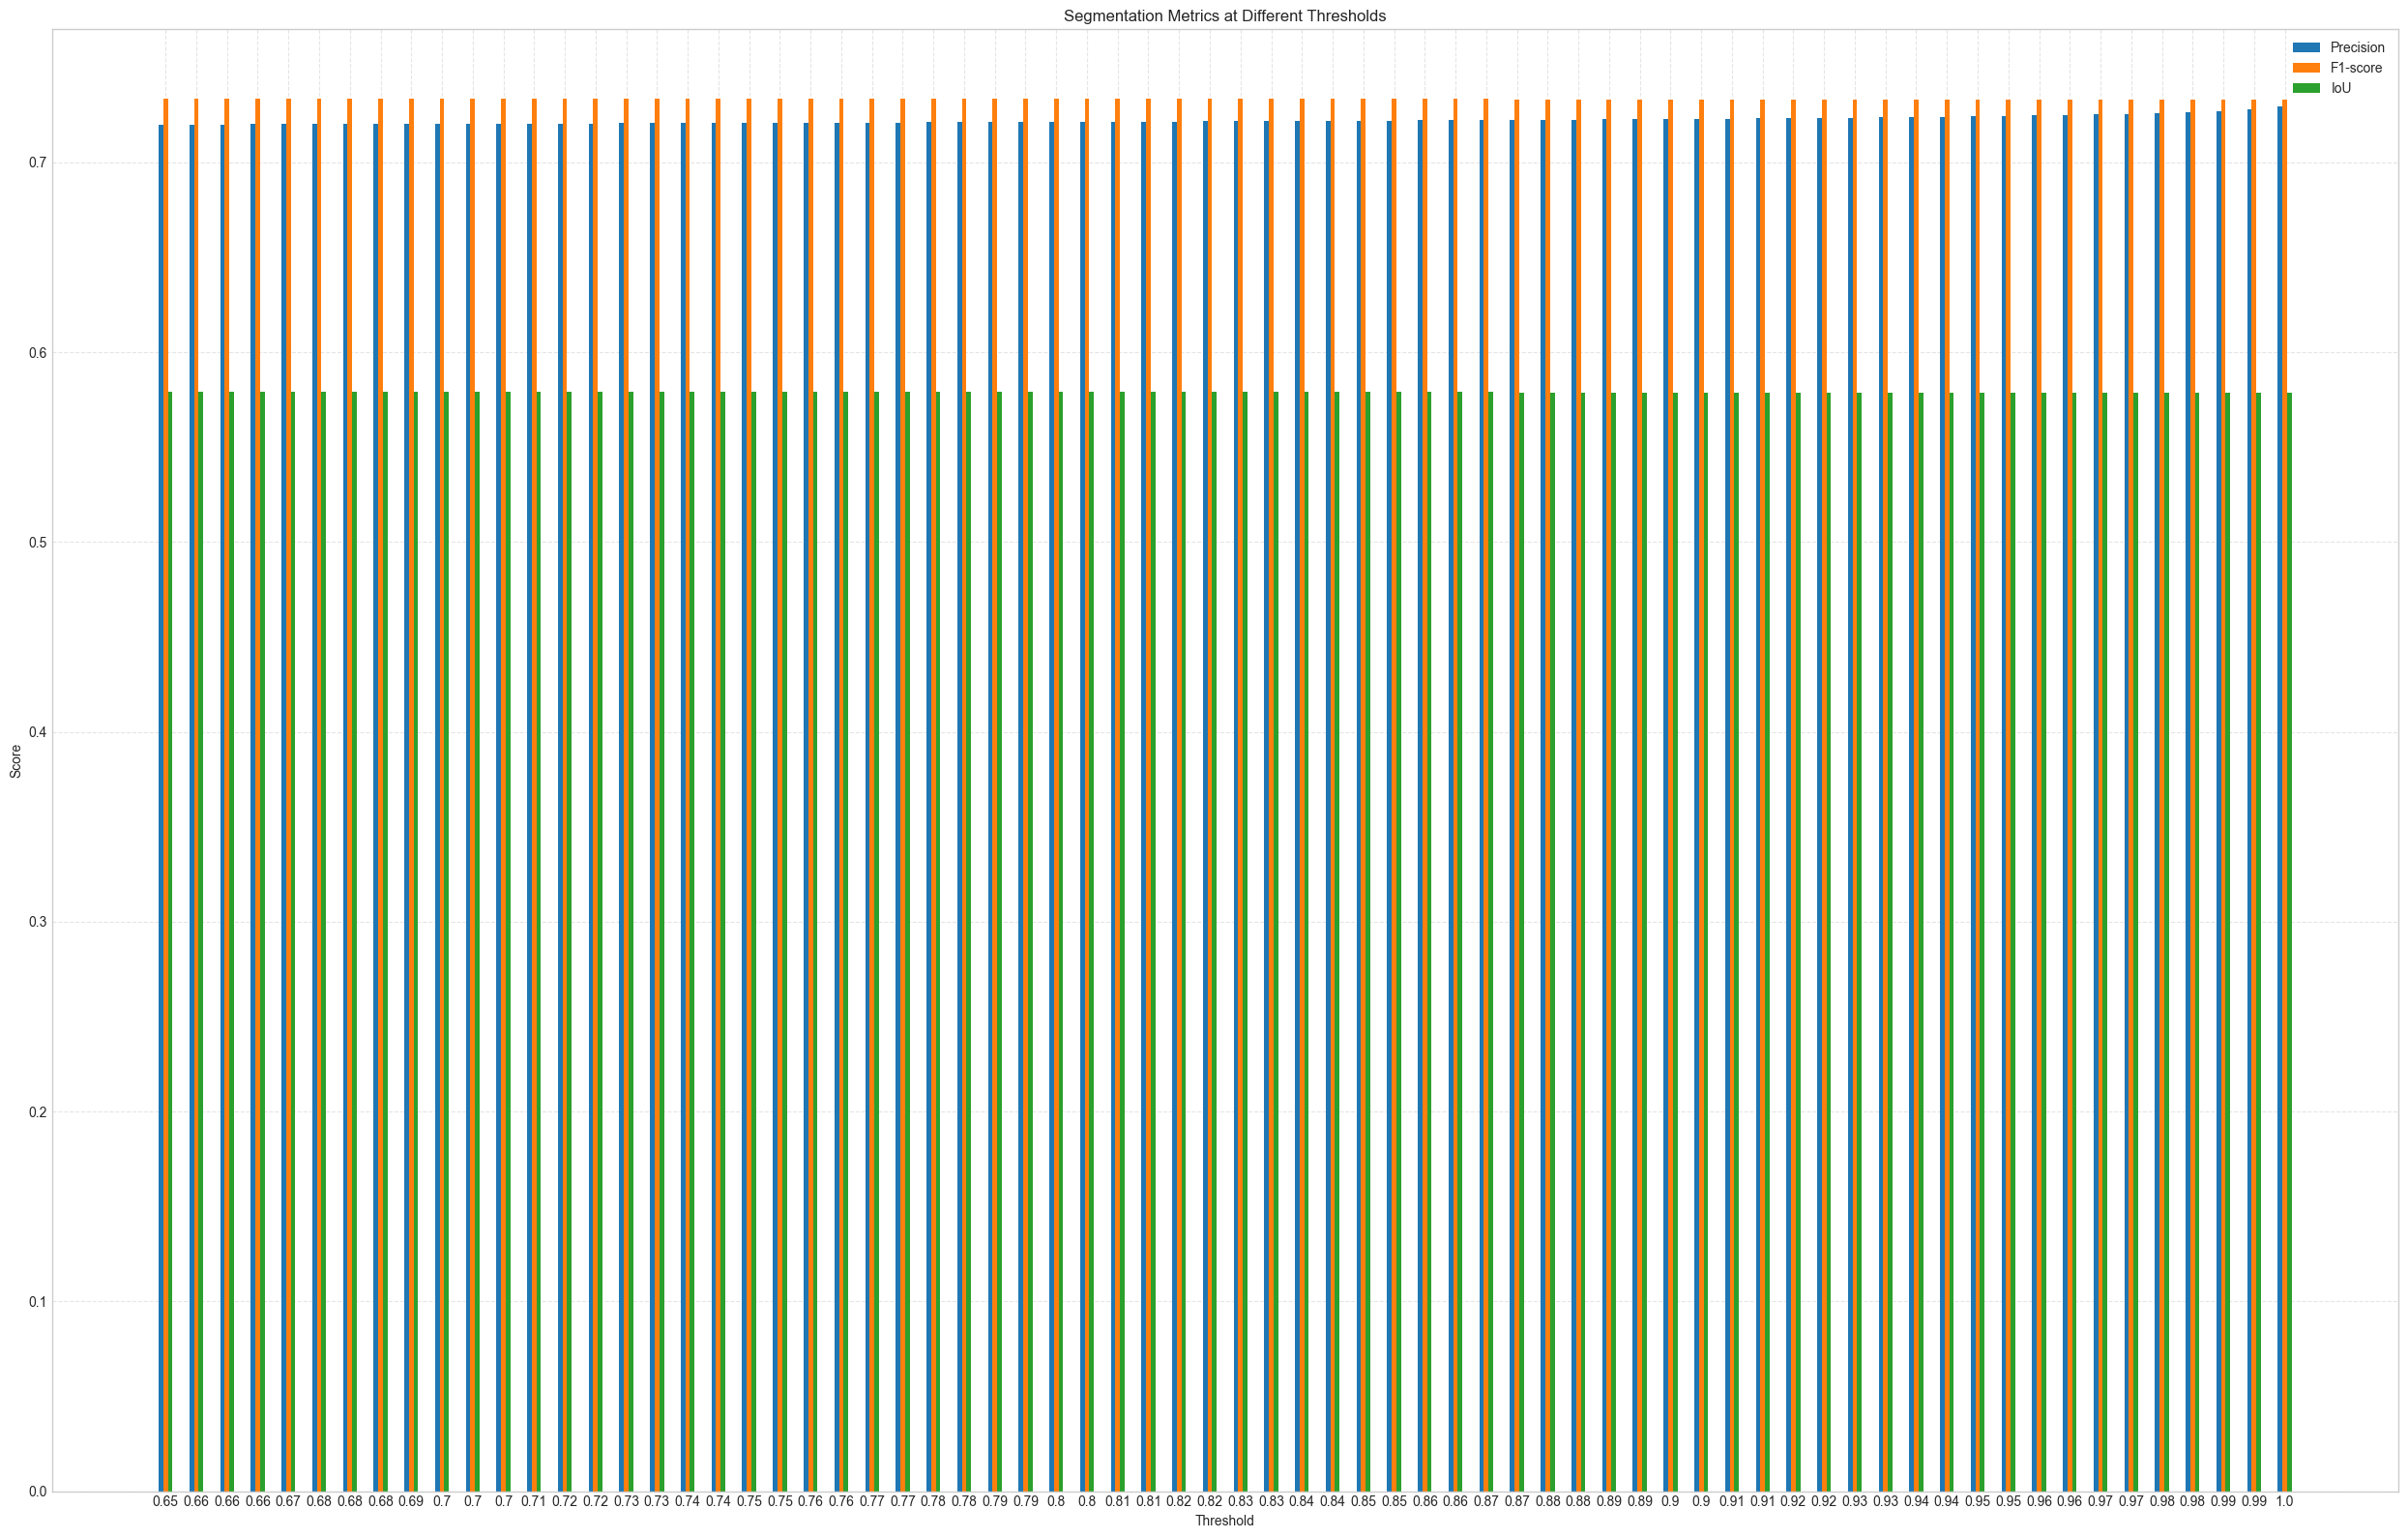

In [18]:
x = [round(t, 2) for t in metrics['threshold']]
x_idx = np.arange(len(x))
width = 0.15

plt.figure(figsize=(25, 16))
plt.bar(x_idx - width, metrics['precision'], width=width, label='Precision')
plt.bar(x_idx, metrics['f1'], width=width, label='F1-score')
plt.bar(x_idx + width, metrics['iou'], width=width, label='IoU')

plt.xticks(x_idx, x)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Segmentation Metrics at Different Thresholds')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()